<div align="center">

## 09. Chest X-Ray Images (Pnenumonia Diagnosis)
</div>

### Importing the main libraries

In [6]:
# libraries
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings(action='ignore')
import pandas as pd
import seaborn as sns
from glob import glob


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, Callback

#bokeh
from bokeh.models import ColumnDataSource, HoverTool, Panel, FactorRange
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.palettes import Spectral6
from bokeh.palettes import Spectral4

### load the data

In [11]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 미니 배치, 에포크 설정
BATCH_SIZE = 16
EPOCHS = 25

In [12]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

TRAIN_PATH1 = ROOT_PATH + '/chest_xray/train/' 
VAL_PATH1 = ROOT_PATH + '/chest_xray/val/'
TEST_PATH1 = ROOT_PATH + '/chest_xray/test/'

print(ROOT_PATH)

/aiffel/aiffel


In [13]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [14]:
# Distribution of images with different category
Categories = ["Train", "Test", "Validation"]
Subcategories = ['Normal', 'Pneumonia']

Train = [1341, 390]
Test = [3875, 8]
Validation = [234, 8]

data = {'Categories':Categories,
        'Train':Train,
        'Test':Test,
        'Validation':Validation}

x = [(categories, subcategories) for categories in Categories for subcategories in Subcategories]
counts = sum(zip(data['Train'], data['Test'], data['Validation']), ())

source = ColumnDataSource(data=dict(x=x, counts=counts, color=Spectral6))

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=800, title="Distribution of images with different category",
           tools="hover, pan, box_zoom, wheel_zoom, reset, save", tooltips= ("@x: @counts"))

p.vbar(x='x', top='counts', width=0.9, color='color', legend_field="x", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"
output_notebook()
show(p)

Loading BokehJS ...

: (데이터 시각화(bokeh)의 코드는 DHRUV MAKWANA의 자료를 참고하였음.)
<br>

먼저 validation의 데이터가 학습을 학습을 하기엔 상당히 적은 양이라 train 데이터와 validation 데이터를 합쳐 비율을 나누어 주고, 메인 클래스와 서브 클래스의 데이터 불균형을 **weight balancing과 borderline-SMOTE** 이 두 가지 방법으로 나눠서 학습을 해 볼 예정입니다. 
<br>

- 데이터 불균형을 맞추기 위한 자료는 아래 논문을 참고.
    - [Learning from imbalanced data,2009](https://sci-hub.se/10.1007/978-3-030-04663-7_4) 

- bokeh
    - [docs](https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html)

**distribution to train and val dataset**

In [15]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


**visualizing the train and test distribution of images**

In [16]:
# Distribution of images with different category

Train_normal = len([filename for filename in train_filenames if "NORMAL" in filename])
Train_pneumonia = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
Validation_normal = len([filename for filename in val_filenames if "NORMAL" in filename])
Validation_pneumonia = len([filename for filename in val_filenames if "PNEUMONIA" in filename])

In [17]:
list = [Train_normal, Train_pneumonia, Validation_normal, Validation_pneumonia]

In [18]:
df = pd.DataFrame(list)
df_t = df.T
df_t.columns = ['Train_normal', 'Train_pneumonia', 'Validation_normal', 'Validation_pneumonia']
print(df_t.columns)
df_t.index = ['count']
print(df_t.index)

Index(['Train_normal', 'Train_pneumonia', 'Validation_normal',
       'Validation_pneumonia'],
      dtype='object')
Index(['count'], dtype='object')


In [19]:
df_t.head()

,Train_normal,Train_pneumonia,Validation_normal,Validation_pneumonia
count,1070,3115,279,768


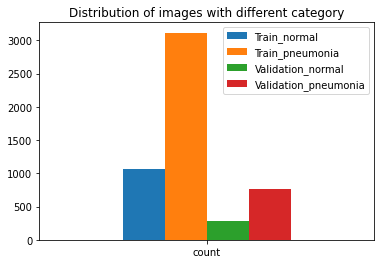

In [20]:
ax = df_t.plot(kind='bar',  title="Distribution of images with different category", rot=0)
plt.show()

In [21]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT)) 

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT)) 

Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047


: train 과 val 데이터의 비가 8대2로 잘 나눠졌으나 정상과 폐렴 데이터의 불균형이 보임.
<br>
해당 부분은 추후 **weight balancing과 borderline-SMOTE** 등을 통해 균형을 잡아줄 예정임. 
<br>
추가적으로 클래스 레이블링이 안 되어 있어 파일 경로를 통해 클래스별 카운팅을 하였으므로 이를 활용해 라벨 데이터를 만들어주는 함수를 생성해야 할 필요성이 있음.

**generate the label data and train dataset, validation dataset**

In [22]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [23]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [24]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [26]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [38]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Visualizing dataset

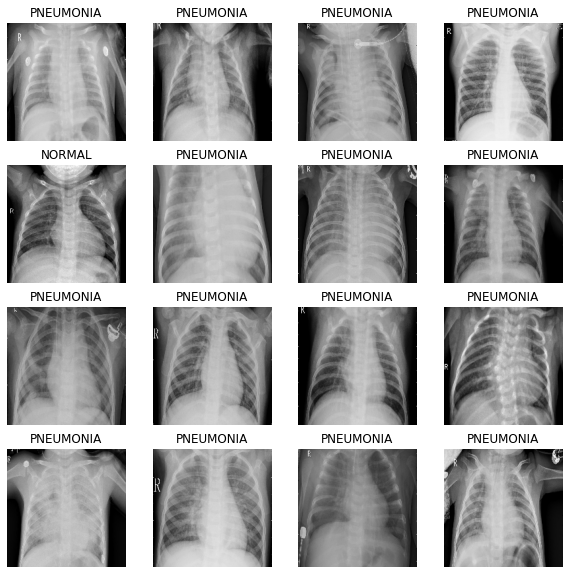

In [19]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### modeling

In [27]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [28]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* * *

**: 총 네 가지 방법으로 학습을 진행**
- **weight balancing**
- **borderline-SMOTE**
- **weight balancing + augmentation**
- **borderline-SMOTE + augmentation**

### method 1. process the data imbalance(weight balancing)

#### weight balancing

In [50]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


In [51]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### model training

In [56]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.97):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


In [57]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [callbacks]
    )

Epoch 1/25
261/261 [==============================] - 57s 191ms/step - loss: 0.1573 - accuracy: 0.9404 - precision: 0.9807 - recall: 0.9379 - val_loss: 0.1161 - val_accuracy: 0.9510 - val_precision: 0.9397 - val_recall: 0.9987
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1580 - accuracy: 0.9423 - precision: 0.9804 - recall: 0.9407 - val_loss: 0.0820 - val_accuracy: 0.9683 - val_precision: 0.9921 - val_recall: 0.9656
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1389 - accuracy: 0.9468 - precision: 0.9851 - recall: 0.9424 - val_loss: 0.0580 - val_accuracy: 0.9837 - val_precision: 0.9873 - val_recall: 0.9911

Reached 93% accuracy so cancelling training!


#### result confirmation

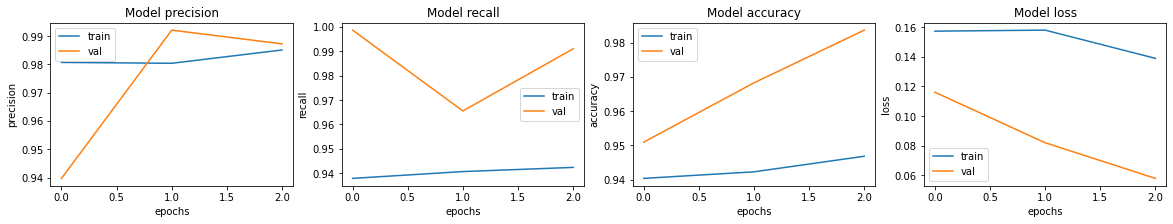

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [168]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.8524 - accuracy: 0.8093 - precision: 0.7673 - recall: 0.9974
Loss: 0.8523758053779602,
Accuracy: 0.8092948794364929,
Precision: 0.7672584056854248,
Recall: 0.9974358677864075


### method 2. process the data imbalance(weight balancing) + augmentation

#### augmentation

In [18]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### visualizing the datasets

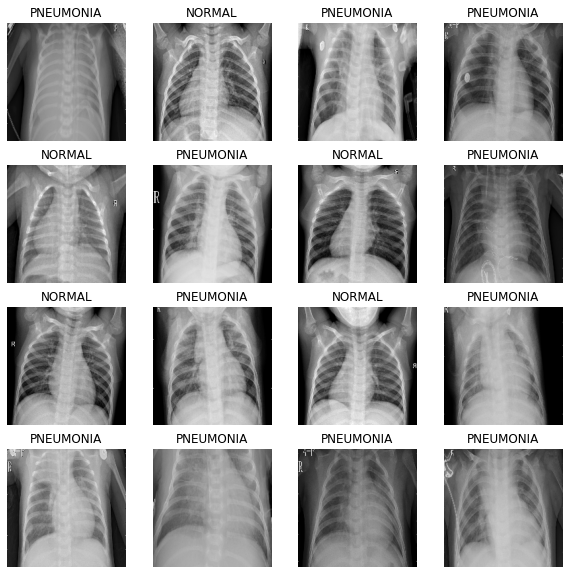

In [26]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

: 랜덤하게 좌우가 반전되었음.

#### weight balancing


In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


#### model training

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [callbacks]
    )

Epoch 1/25
261/261 [==============================] - 99s 230ms/step - loss: 0.3548 - accuracy: 0.8379 - precision: 0.9616 - recall: 0.8143 - val_loss: 0.7454 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2311 - accuracy: 0.9136 - precision: 0.9689 - recall: 0.9130 - val_loss: 1.6528 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.2002 - accuracy: 0.9262 - precision: 0.9785 - recall: 0.9212 - val_loss: 0.1238 - val_accuracy: 0.9510 - val_precision: 0.9408 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1938 - accuracy: 0.9236 - precision: 0.9744 - recall: 0.9213 - val_loss: 0.1009 - val_accuracy: 0.9615 - val_precision: 0.9583 - val_recall: 0.9908
Epoch 5/25
261/261 [==============================] - 52s 201ms/step - loss: 0.1760 - accura

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.5906 - accuracy: 0.8029 - precision: 0.7654 - recall: 0.9872
Loss: 0.5906260013580322,
Accuracy: 0.8028846383094788,
Precision: 0.7654075622558594,
Recall: 0.9871794581413269


: 랜덤하게 좌우를 반전 시켰지만 정확도는 변함이 없음.


처음으로 다시 돌아가서 데이터 셋 분류부터 진행해야 할 필요성이 있음.

### method 3. process datasets


- train val test데이터의 정상, 폐렴 데이터를 각각 8:1:1 분리 후 따로 저장
- ImageDataGenerator을 활용한 이미지 augmentation
- 새로운 모델 설계 및 학습 진행

In [4]:
TRAIN_PATH1 = ROOT_PATH + '/chest_xray/train/' 
VAL_PATH1 = ROOT_PATH + '/chest_xray/val/'
TEST_PATH1 = ROOT_PATH + '/chest_xray/test/'

In [6]:
from glob import glob

Normal = glob(TRAIN_PATH1 + "NORMAL/*") + glob(TEST_PATH1 + "NORMAL/*") + glob(VAL_PATH1 + "NORMAL/*")
Pneumonia = glob(TRAIN_PATH1 + "PNEUMONIA/*") + glob(TEST_PATH1 + "PNEUMONIA/*") + glob(VAL_PATH1 + "PNEUMONIA/*")

print('normal images:{}'.format(len(Normal)))
print('pneumonia images:{}'.format(len(Pneumonia)))

normal images:1583
pneumonia images:4273


In [7]:
# For all normal images
Train_normal = Normal[:1266]
Test_normal = Normal[1266:1424]
Validation_normal = Normal[1424:]

# For all pneumonia images
Train_pneumonia = Pneumonia[:3418]
Test_pneumonia = Pneumonia[3418:3845]
Validation_pneumonia = Pneumonia[3845:]

In [8]:
# Make new directory to store our balanced data
"""
Train
    Normal
    Pneumonia
Test
    Normal
    Pneumonia
Validation
    Normal
    Pneumonia
"""

!mkdir Train
!mkdir Test
!mkdir Validation
!mkdir Train/Normal
!mkdir Train/Pneumonia
!mkdir Test/Normal
!mkdir Test/Pneumonia
!mkdir Validation/Normal
!mkdir Validation/Pneumonia

In [10]:
import shutil

# copy all images from Train_pneumonia to Train/Pneumonia
for i in Train_pneumonia:
    shutil.copy(i, "Train/Pneumonia/")
print("Copied all images from Train_pneumonia to Train/Pneumonia")
    
# copy all images from Test_pneumonia to Test/Pneumonia
for i in Test_pneumonia:
    shutil.copy(i, "Test/Pneumonia/")
print("Copied all images from Test_pneumonia to Test/Pneumonia")
    
# copy all images from Validation_pneumonia to Validation/Pneumonia
for i in Validation_pneumonia:
    shutil.copy(i, "Validation/Pneumonia/")
print("Copied all images from Validation_pneumonia to Validation/Pneumonia")

# copy all images from Train_normal to Train/Normal
for i in Train_normal:
    shutil.copy(i, "Train/Normal/")
print("Copied all images from Train_normal to Train/Normal")

# copy all images from Test_normal to Test/Normal
for i in Test_normal:
    shutil.copy(i, "Test/Normal/")
print("Copied all images from Test_normal to Test/Normal")
    
# copy all images from Validation_normal to Validation/Normal
for i in Validation_normal:
    shutil.copy(i, "Validation/Normal/")
print("Copied all images from Validation_normal to Validation/Normal")

Copied all images from Train_pneumonia to Train/Pneumonia
Copied all images from Test_pneumonia to Test/Pneumonia
Copied all images from Validation_pneumonia to Validation/Pneumonia
Copied all images from Train_normal to Train/Normal
Copied all images from Test_normal to Test/Normal
Copied all images from Validation_normal to Validation/Normal


In [4]:
# setup file structure
train_dir = "Train/"
test_dir = "Test/"
val_dir = "Validation/"

In [7]:
# check new data distribution
print("Number of images in Train is {}".format(len(glob(train_dir + "*/*"))))
print("Number of images in Test is {}".format(len(glob(test_dir + "*/*"))))
print("Number of images in Validation is {}".format(len(glob(val_dir + "*/*"))))

Number of images in Train is 4684
Number of images in Test is 585
Number of images in Validation is 587


In [9]:
# image preprocessing
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
batch_size = 16
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224), 
                                                 batch_size = batch_size, 
                                                 class_mode = "binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size = (224, 224),
                                          batch_size = batch_size,
                                          class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 4684 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid'),
])

In [42]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [43]:
with tf.device('/GPU:0'):
    #model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [45]:
with tf.device('/GPU:0'):
    history = model.fit(
        training_set,
        steps_per_epoch=training_set.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_set,
        validation_steps=val_set.samples // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [callbacks]
    )

Epoch 1/25
292/292 [==============================] - 96s 323ms/step - loss: 0.4644 - accuracy: 0.7521 - precision: 0.9350 - recall: 0.7095 - val_loss: 0.3459 - val_accuracy: 0.8507 - val_precision: 0.9154 - val_recall: 0.8762
Epoch 2/25
292/292 [==============================] - 99s 338ms/step - loss: 0.3634 - accuracy: 0.8417 - precision: 0.9543 - recall: 0.8224 - val_loss: 0.5708 - val_accuracy: 0.6927 - val_precision: 0.9728 - val_recall: 0.5952
Epoch 3/25
292/292 [==============================] - 94s 322ms/step - loss: 0.3370 - accuracy: 0.8582 - precision: 0.9629 - recall: 0.8380 - val_loss: 0.5666 - val_accuracy: 0.7205 - val_precision: 0.9744 - val_recall: 0.6333
Epoch 4/25
292/292 [==============================] - 98s 335ms/step - loss: 0.3034 - accuracy: 0.8719 - precision: 0.9686 - recall: 0.8520 - val_loss: 0.3425 - val_accuracy: 0.8663 - val_precision: 0.9455 - val_recall: 0.8667
Epoch 5/25
292/292 [==============================] - 97s 333ms/step - loss: 0.2792 - accura

In [49]:
loss, acc, prec, rec = model.evaluate(test_set)

37/37 [==============================] - 10s 264ms/step - loss: 0.1966 - accuracy: 0.9248 - precision: 0.9614 - recall: 0.9344
